# Monte Carlo Simulation for Retirement Portfolio
## Introduction
This notebook performs a Monte Carlo simulation to project the future value of a retirement portfolio, focusing on mutual funds and individual risk aversion. The goal is to provide insights into how different investment strategies can meet retirement needs over a long-term horizon.

The user can input mutual fund data, risk profiles, contribution amounts, and retirement horizons to see potential portfolio outcomes. This simulation can help determine whether a portfolio meets an individual's retirement goals.


## How to Install Necessary Libraries

1. **Using Python (Mac or Windows)**:
   - Open **Terminal (Mac)** or **Command Prompt (Windows)**.
   - Use `pip` to install the required libraries:
     ```bash
     pip install numpy pandas matplotlib yfinance
     ```

2. **Using Jupyter Notebooks (Mac or Windows)**:
   - Install libraries directly from a Jupyter Notebook cell by prefixing the command with `!`:
     ```python
     !pip install numpy pandas matplotlib yfinance
     ```

3. **Using Conda (Mac or Windows)**:
   - If you're using **Anaconda**, open **Terminal (Mac)** or **Anaconda Prompt (Windows)**.
   - Use `conda` to install the required libraries:
     ```bash
     conda install numpy pandas matplotlib
     ```
   - For additional channels like `conda-forge`, use:
     ```bash
     conda install -c conda-forge yfinance
     ```


## Importing Necessary Libraries
We'll need several libraries for data manipulation, numerical computation, and simulation:
- `numpy` for random number generation and matrix operations.
- `pandas` for handling data.
- `matplotlib` for plotting results.
- `scipy.stats` for statistical distributions.
- `yfinance` to fetch stock/fund data from Yahoo Finance


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf

# Defining Parameters for the Simulation
In this section, you define all of the parameters for the simulation in one place. This helps keep the code organized and makes it easy to adjust the inputs, such as:
- **`fund_tickers`**: The list of ticker symbols for the mutual funds or ETFs you want to include in your portfolio.
- **`weights`**: The weight of each fund in the portfolio. Make sure the weights sum to 1.
- **`initial_investment`**: The amount of money you start with.
- **`years_to_retirement`**: The number of years to simulate before retirement.

### Considerations:
- You can adjust **`weights`** to reflect a more diversified portfolio by adding more funds.
- Consider automating the summation check for `weights` to ensure they add up to 1.


In [90]:
# Define portfolio parameters
fund_tickers = ['VTI', 'AGG', 'VOO']  # List of mutual fund or ETF tickers
weights = [0.4, 0.35, 0.25]  # Portfolio weights for each fund (must sum to 1)
risk_aversion = 1  # 1 is neutral, <1 is risk-seeking, >1 is risk-averse
initial_investment = 100000  # Initial investment in USD
annual_contribution = 10000  # Annual contribution in USD
num_simulations = 10000  # Number of Monte Carlo simulations

# Additional parameters for more personalized retirement modeling
life_expectancy = 90  # Expected age to live up to
retirement_age = 65  # Age at which the individual plans to retire
current_age = 35  # Current age of the individual
years_to_retirement = retirement_age - current_age

withdrawal_rate = 0.04  # Percentage of portfolio withdrawn annually during retirement
annual_expenses = 40000  # Expected annual expenses during retirement (in USD)
inflation_rate = 0.02  # Expected annual inflation rate (e.g., 2%)

# Importing Historical Data (Yahoo Finance)
This function uses the `yfinance` library to download historical data for the specified tickers. It calculates the average annual return and volatility for each fund.

## Alternative Ways to Add Data:
- **Morningstar**: If you have a paid subscription to Morningstar, you can use their data as a source. Modify the function to access the Morningstar API to fetch detailed and accurate mutual fund data.

- **Manual Entry**: You can manually enter the expected returns and volatilities for each fund without using an API. For example, you could create a CSV file with columns like 'Fund Name', 'Expected Return', and 'Volatility', and then import it into the notebook using `pandas`:
  ```python
  df_manual = pd.read_csv("path_to_your_csv.csv")
  expected_returns = df_manual['Expected Return'].values
  volatility = df_manual['Volatility'].values

In [91]:
def fetch_data_yfinance(fund_tickers):
    """
    Fetch historical data for given tickers (mutual funds or ETFs) from Yahoo Finance.
    
    Args:
    - fund_tickers (list): List of ticker symbols for the funds
    
    Returns:
    - expected_returns (np.array): Array of expected annual returns
    - volatility (np.array): Array of volatilities (standard deviation of returns)
    """
    expected_returns = []
    volatility = []
    
    for ticker in fund_tickers:
        # Fetch historical data (5 years of monthly data as an example)
        data = yf.download(ticker, period="5y", interval="1mo")
        data['Return'] = data['Adj Close'].pct_change()

        # Calculate the average annual return and volatility
        avg_return = data['Return'].mean() * 12  # Annualized monthly return
        vol = data['Return'].std() * np.sqrt(12)  # Annualized volatility
        
        expected_returns.append(avg_return)
        volatility.append(vol)
    
    return np.array(expected_returns), np.array(volatility)

# Fetch data
expected_returns, volatility = fetch_data_yfinance(fund_tickers)

# Ensure weights match the number of funds
if len(weights) != len(expected_returns):
    raise ValueError("The number of weights must match the number of funds.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Adjusting for Risk Aversion 
- Adjust expected returns and volatilities based on the risk aversion level.
- More risk-averse individuals will have lower returns and lower volatility.

In [92]:
adjusted_returns = np.array(expected_returns) / risk_aversion
adjusted_volatility = np.array(volatility) * risk_aversion

# Monte Carlo Simulation Function
- This function simulates the future value of a retirement portfolio based on the defined parameters.

In [93]:
def monte_carlo_simulation(initial_investment, weights, adjusted_returns, adjusted_volatility, 
                           years_to_retirement, annual_contribution, num_simulations, withdrawal_rate, 
                           retirement_years, inflation_rate, annual_expenses):
    """
    Simulate the future value of a retirement portfolio using Monte Carlo simulations.
    
    Args:
    - initial_investment (float): Starting portfolio value
    - weights (list): Portfolio weights for each mutual fund
    - adjusted_returns (np.array): Adjusted expected returns based on risk aversion
    - adjusted_volatility (np.array): Volatility of each mutual fund
    - years_to_retirement (int): Time horizon for simulation (e.g., 30 years)
    - annual_contribution (float): Contribution amount each year
    - num_simulations (int): Number of simulations to run
    - withdrawal_rate (float): Withdrawal rate during retirement
    - retirement_years (int): Number of years in retirement
    - inflation_rate (float): Expected annual inflation rate
    - annual_expenses (float): Expected annual expenses during retirement
    
    Returns:
    - portfolio_values (list): Simulated portfolio values at retirement
    - retirement_outcomes (list): Portfolio values at the end of retirement
    - max_drawdowns (list): Maximum drawdowns during the simulation
    """
    portfolio_values = []
    retirement_outcomes = []
    max_drawdowns = []

    for _ in range(num_simulations):
        # Initialize portfolio value
        portfolio_value = initial_investment
        max_value = portfolio_value
        drawdown = 0

        # Accumulation phase - pre-retirement
        for year in range(years_to_retirement):
            annual_return = np.random.normal(adjusted_returns, adjusted_volatility)
            if len(annual_return) != len(weights):
                raise ValueError("The number of weights must match the number of returns.")
            portfolio_value = portfolio_value * (1 + np.dot(weights, annual_return))
            portfolio_value += annual_contribution
            max_value = max(max_value, portfolio_value)
            drawdown = min(drawdown, (portfolio_value - max_value) / max_value)
        
        portfolio_values.append(portfolio_value)
        max_drawdowns.append(drawdown)

        # Retirement phase - withdrawals and inflation adjustments
        for year in range(retirement_years):
            annual_return = np.random.normal(adjusted_returns, adjusted_volatility)
            portfolio_value = portfolio_value * (1 + np.dot(weights, annual_return))
            annual_withdrawal = annual_expenses * (1 + inflation_rate) ** year
            portfolio_value -= annual_withdrawal
            if portfolio_value <= 0:
                portfolio_value = 0
                break
        
        retirement_outcomes.append(portfolio_value)

    return portfolio_values, retirement_outcomes, max_drawdowns

# Calculate retirement years based on current age, retirement age, and life expectancy
retirement_years = life_expectancy - retirement_age

# Running the Simulation
Run the Monte Carlo simulation using the defined parameters and display the results.

In [94]:
portfolio_values, retirement_outcomes, max_drawdowns = monte_carlo_simulation(initial_investment, weights, adjusted_returns, 
                                                                              adjusted_volatility, years_to_retirement, 
                                                                              annual_contribution, num_simulations, 
                                                                              withdrawal_rate, retirement_years, 
                                                                              inflation_rate, annual_expenses)

# Convert results to DataFrame for easier analysis
df_simulations = pd.DataFrame({
    'Portfolio Value at Retirement': portfolio_values,
    'Portfolio Value at End of Retirement': retirement_outcomes,
    'Max Drawdown': max_drawdowns
})

# Plotting the Results
Visualize the distribution of portfolio values at retirement.

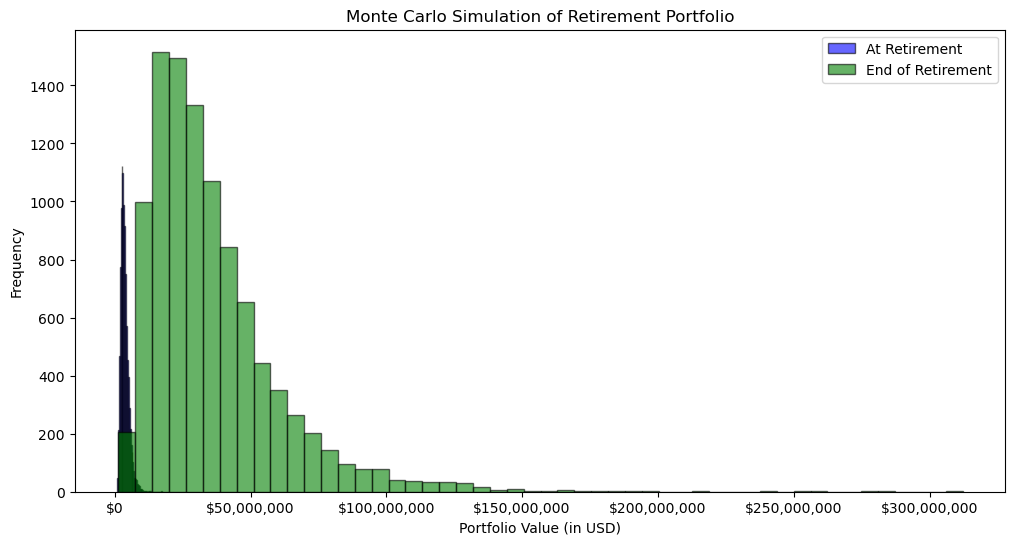

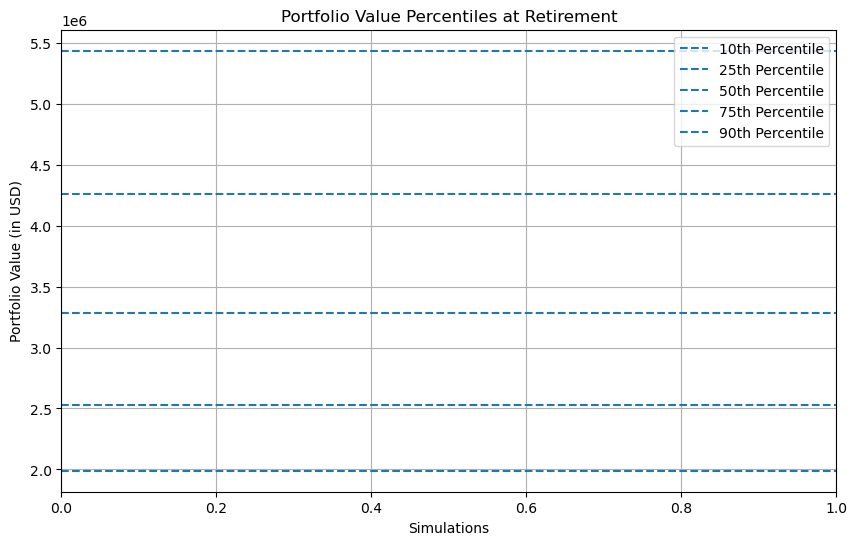

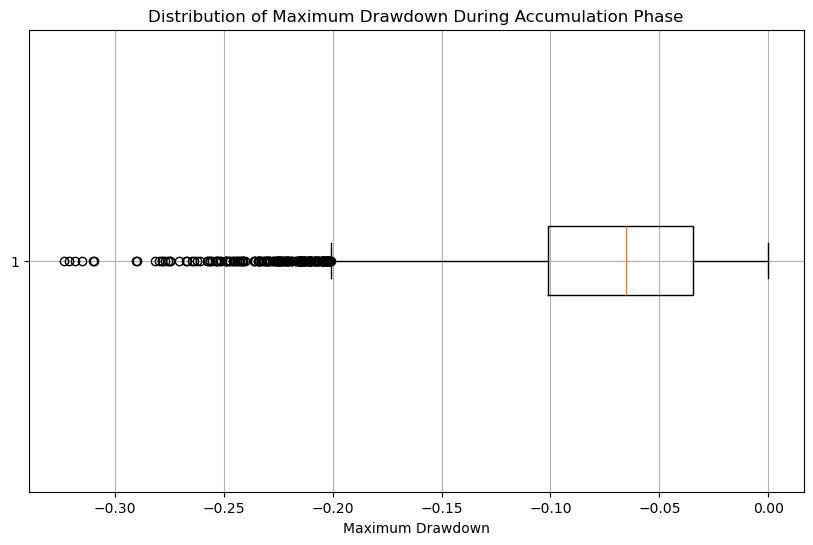

Probability of having enough funds to cover annual expenses: 100.00%


In [95]:
# Histogram of portfolio values at retirement and end of retirement
plt.figure(figsize=(12, 6))
plt.hist(df_simulations['Portfolio Value at Retirement'], bins=50, color='blue', edgecolor='black', alpha=0.6, label='At Retirement')
plt.hist(df_simulations['Portfolio Value at End of Retirement'], bins=50, color='green', edgecolor='black', alpha=0.6, label='End of Retirement')
plt.title('Monte Carlo Simulation of Retirement Portfolio')
plt.xlabel('Portfolio Value (in USD)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')  # Ensure x-axis values are displayed in plain format
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))  # Add commas to x-axis values
plt.legend()
plt.show()

# Line plot of expected portfolio value over time with different percentiles
percentiles = [10, 25, 50, 75, 90]
percentile_values = np.percentile(portfolio_values, percentiles)
plt.figure(figsize=(10, 6))
for i, perc in enumerate(percentiles):
    plt.axhline(percentile_values[i], linestyle='--', label=f'{perc}th Percentile')
plt.xlabel('Simulations')
plt.ylabel('Portfolio Value (in USD)')
plt.title('Portfolio Value Percentiles at Retirement')
plt.legend()
plt.grid(True)
plt.show()

# Boxplot for max drawdown
plt.figure(figsize=(10, 6))
plt.boxplot(df_simulations['Max Drawdown'], vert=False)
plt.xlabel('Maximum Drawdown')
plt.title('Distribution of Maximum Drawdown During Accumulation Phase')
plt.grid(True)
plt.show()

# Probability of having enough for annual expenses during retirement
sufficient_funds = df_simulations['Portfolio Value at End of Retirement'] >= annual_expenses * retirement_years
probability_sufficient = sufficient_funds.mean() * 100
print(f'Probability of having enough funds to cover annual expenses: {probability_sufficient:.2f}%')

# Conclusion
- The Monte Carlo simulation provides a distribution of possible outcomes for the retirement portfolio.
- The simulation includes both the accumulation phase (pre-retirement) and the withdrawal phase (post-retirement), allowing for a more comprehensive understanding of potential retirement outcomes.
- This helps in making informed decisions about contribution levels, asset allocation, and withdrawal strategies.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Expected Annual Portfolio Return (based on historical data): 10.20%
Expected Annual Portfolio Volatility (based on historical data): 13.55%


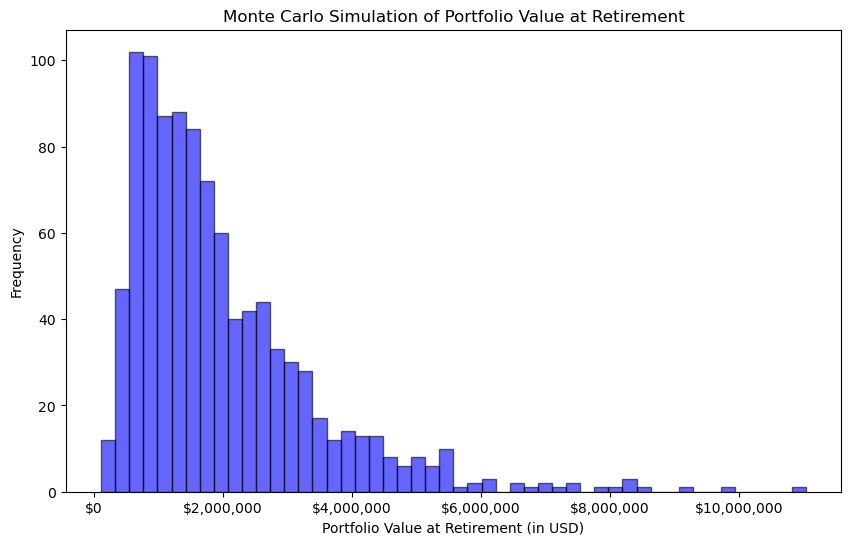

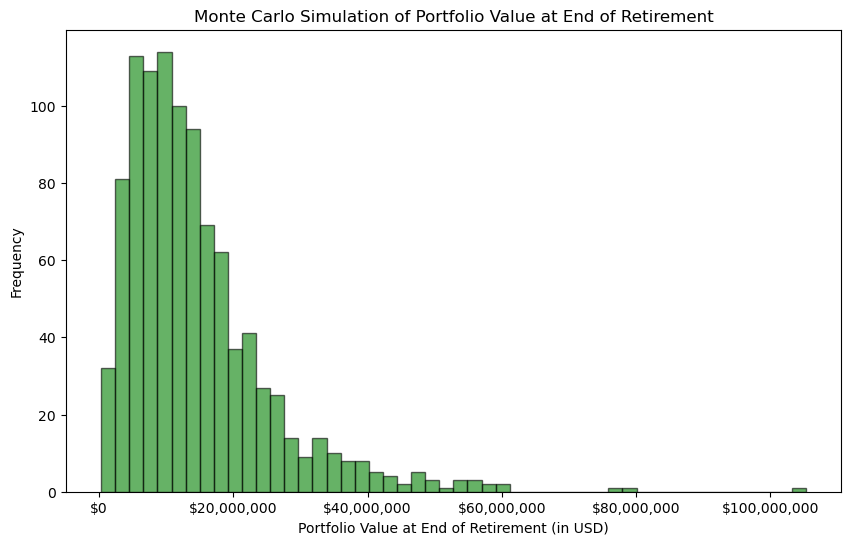

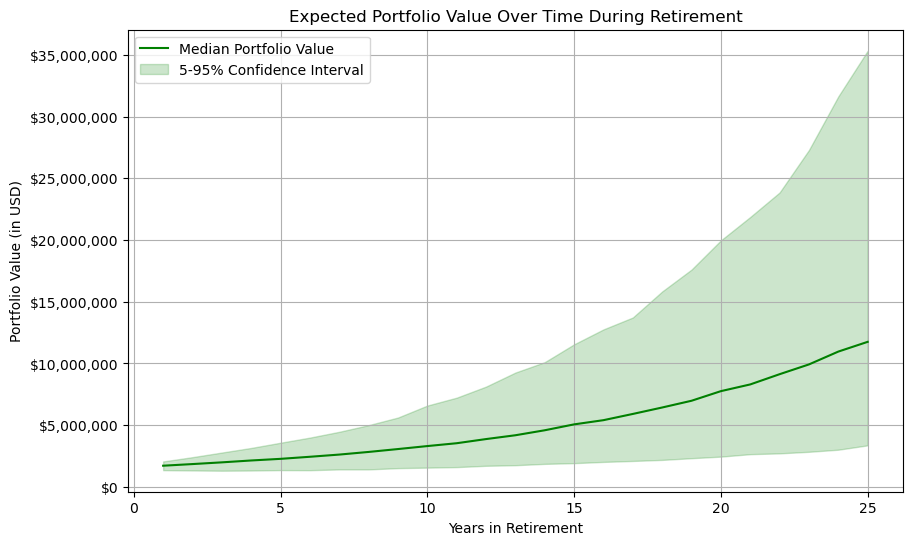

Expected portfolio value at retirement start (in 30 years): $1,584,478.95
Expected portfolio value at end of retirement (after 25 years): $11,754,619.91


In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf

# --- Parameter Definition ---
# Define portfolio parameters
fund_tickers = ['VTI', 'AGG', 'VOO']  # List of mutual fund or ETF tickers
weights = [0.4, 0.35, 0.25]  # Portfolio weights for each fund (must sum to 1)
initial_investment = 100000  # Initial investment in USD
annual_contribution = 5000  # Annual contribution in USD
years_to_retirement = 30  # Number of years to simulate
num_simulations = 1000  # Number of Monte Carlo simulations

# Additional parameters for more personalized retirement modeling
life_expectancy = 90  # Expected age to live up to
retirement_age = 65  # Age at which the individual plans to retire
current_age = 35  # Current age of the individual
annual_expenses = 40000  # Expected annual expenses during retirement (in USD)
inflation_rate = 0.02  # Expected annual inflation rate (e.g., 2%)

# --- Importing Data ---
# Fetch historical data for the specified mutual fund or ETF tickers using Yahoo Finance.
# This section calculates the expected return and volatility for each fund.

def fetch_data_yfinance(fund_tickers):
    """
    Fetch historical data for given tickers (mutual funds or ETFs) from Yahoo Finance.
    
    Args:
    - fund_tickers (list): List of ticker symbols for the funds
    
    Returns:
    - returns_data (pd.DataFrame): DataFrame of historical returns for each fund
    - expected_returns (np.array): Array of expected annual returns
    """
    returns_data = pd.DataFrame()
    expected_returns = []
    
    for ticker in fund_tickers:
        # Fetch historical data (5 years of monthly data as an example)
        data = yf.download(ticker, period="5y", interval="1mo")
        data['Return'] = data['Adj Close'].pct_change()

        # Calculate the average annual return
        avg_return = data['Return'].mean() * 12  # Annualized monthly return
        expected_returns.append(avg_return)

        # Store returns data
        returns_data[ticker] = data['Return']
    
    return returns_data, np.array(expected_returns)

# Fetch data
returns_data, expected_returns = fetch_data_yfinance(fund_tickers)

# Ensure weights match the number of funds
if len(weights) != len(expected_returns):
    raise ValueError("The number of weights must match the number of funds.")

# --- Expected Portfolio Return and Volatility ---
# Calculate the expected return and volatility of the portfolio based on historical data
expected_portfolio_return = np.dot(weights, expected_returns)

# Calculate the covariance matrix of the returns
cov_matrix = returns_data.cov() * 12  # Annualized covariance matrix
expected_portfolio_volatility = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))

print(f'Expected Annual Portfolio Return (based on historical data): {expected_portfolio_return * 100:.2f}%')
print(f'Expected Annual Portfolio Volatility (based on historical data): {expected_portfolio_volatility * 100:.2f}%')

# --- Accumulation Phase Monte Carlo Simulation Function ---

def accumulation_phase_simulation(initial_investment, weights, expected_returns, expected_volatility, 
                                  years_to_retirement, annual_contribution, num_simulations):
    """
    Simulate the future value of a retirement portfolio during the accumulation phase.
    
    Args:
    - initial_investment (float): Starting portfolio value
    - weights (list): Portfolio weights for each mutual fund
    - expected_returns (np.array): Expected returns based on historical data
    - expected_volatility (float): Volatility of the portfolio
    - years_to_retirement (int): Time horizon for simulation (e.g., 30 years)
    - annual_contribution (float): Contribution amount each year
    - num_simulations (int): Number of simulations to run
    
    Returns:
    - final_values (list): List of final portfolio values at retirement for each simulation
    - all_yearly_values (list): List of portfolio values over time for each simulation
    """
    final_values = []
    all_yearly_values = []

    for _ in range(num_simulations):
        portfolio_value = initial_investment
        yearly_values = []

        for year in range(years_to_retirement):
            annual_return = np.random.normal(expected_returns.mean(), expected_volatility)
            portfolio_value = portfolio_value * (1 + annual_return) + annual_contribution
            yearly_values.append(portfolio_value)
        
        final_values.append(portfolio_value)
        all_yearly_values.append(yearly_values)
    
    return final_values, all_yearly_values

# --- Running Accumulation Phase Simulation ---
accumulation_results, accumulation_yearly_values = accumulation_phase_simulation(
    initial_investment, weights, expected_returns, expected_portfolio_volatility, years_to_retirement, 
    annual_contribution, num_simulations)

# Plotting Accumulation Phase Results
plt.figure(figsize=(10, 6))
plt.hist(accumulation_results, bins=50, color='blue', edgecolor='black', alpha=0.6)
plt.title('Monte Carlo Simulation of Portfolio Value at Retirement')
plt.xlabel('Portfolio Value at Retirement (in USD)')
plt.ylabel('Frequency')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))
plt.show()

# --- Withdrawal Phase Monte Carlo Simulation Function ---

def withdrawal_phase_simulation(initial_portfolio_value, expected_returns, expected_volatility, 
                                 retirement_years, num_simulations, inflation_rate, annual_expenses):
    """
    Simulate the future value of a retirement portfolio during the withdrawal phase.
    
    Args:
    - initial_portfolio_value (float): Portfolio value at the start of retirement
    - expected_returns (np.array): Expected returns based on historical data
    - expected_volatility (float): Volatility of the portfolio
    - retirement_years (int): Number of years in retirement
    - num_simulations (int): Number of simulations to run
    - inflation_rate (float): Expected annual inflation rate
    - annual_expenses (float): Expected annual expenses during retirement
    
    Returns:
    - final_values (list): List of final portfolio values at the end of retirement for each simulation
    - all_yearly_values (list): List of portfolio values over time for each simulation
    """
    final_values = []
    all_yearly_values = []

    for _ in range(num_simulations):
        portfolio_value = initial_portfolio_value
        yearly_values = []

        for year in range(retirement_years):
            # Withdraw annual expenses adjusted for inflation
            annual_withdrawal = annual_expenses * ((1 + inflation_rate) ** year)
            portfolio_value -= annual_withdrawal

            # If portfolio is depleted
            if portfolio_value <= 0:
                portfolio_value = 0
                yearly_values.append(portfolio_value)
                break

            # Apply annual return on the remaining portfolio
            annual_return = np.random.normal(expected_returns.mean(), expected_volatility)
            portfolio_value = portfolio_value * (1 + annual_return)
            yearly_values.append(portfolio_value)
        
        final_values.append(portfolio_value)
        all_yearly_values.append(yearly_values)
    
    return final_values, all_yearly_values

# Calculate retirement years based on current age, retirement age, and life expectancy
retirement_years = life_expectancy - retirement_age

# --- Running Withdrawal Phase Simulation ---
withdrawal_results, withdrawal_yearly_values = withdrawal_phase_simulation(
    np.median(accumulation_results), expected_returns, expected_portfolio_volatility, 
    retirement_years, num_simulations, inflation_rate, annual_expenses)

# Plotting Withdrawal Phase Results
plt.figure(figsize=(10, 6))
plt.hist(withdrawal_results, bins=50, color='green', edgecolor='black', alpha=0.6)
plt.title('Monte Carlo Simulation of Portfolio Value at End of Retirement')
plt.xlabel('Portfolio Value at End of Retirement (in USD)')
plt.ylabel('Frequency')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))
plt.show()

# Line plot of expected portfolio growth over time (withdrawal phase)
all_yearly_values = np.array([np.pad(y, (0, retirement_years - len(y)), constant_values=np.nan) for y in withdrawal_yearly_values], dtype=float)
median_values = np.nanpercentile(all_yearly_values, 50, axis=0)
lower_bound = np.nanpercentile(all_yearly_values, 5, axis=0)
upper_bound = np.nanpercentile(all_yearly_values, 95, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(median_values) + 1), median_values, label='Median Portfolio Value', color='green')
plt.fill_between(range(1, len(median_values) + 1), lower_bound, upper_bound, color='green', alpha=0.2, label='5-95% Confidence Interval')
plt.xlabel('Years in Retirement')
plt.ylabel('Portfolio Value (in USD)')
plt.title('Expected Portfolio Value Over Time During Retirement')
plt.legend()
plt.grid(True)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))
plt.show()

# Print summary statistics for accumulation and withdrawal phases
print(f'Expected portfolio value at retirement start (in {years_to_retirement} years): ${np.median(accumulation_results):,.2f}')
print(f'Expected portfolio value at end of retirement (after {retirement_years} years): ${np.median(withdrawal_results):,.2f}')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Expected Annual Portfolio Return: 10.20%
Expected Annual Portfolio Volatility: 13.55%


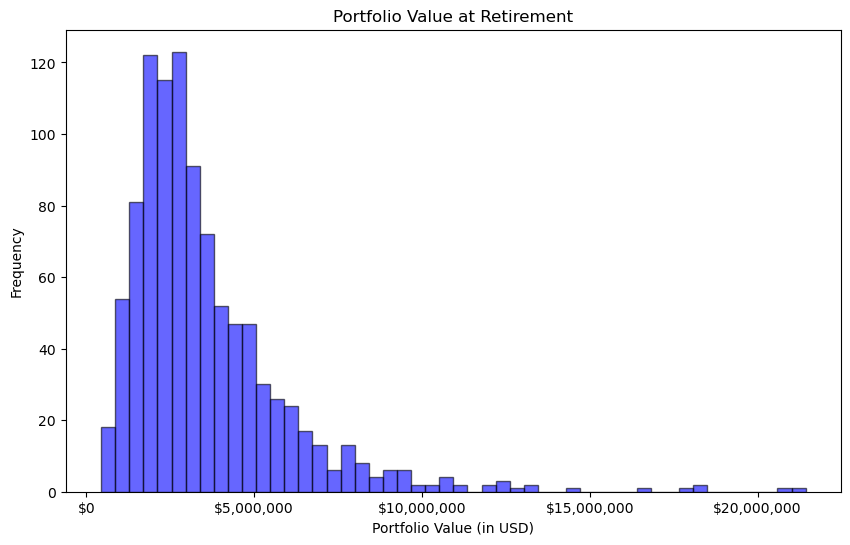

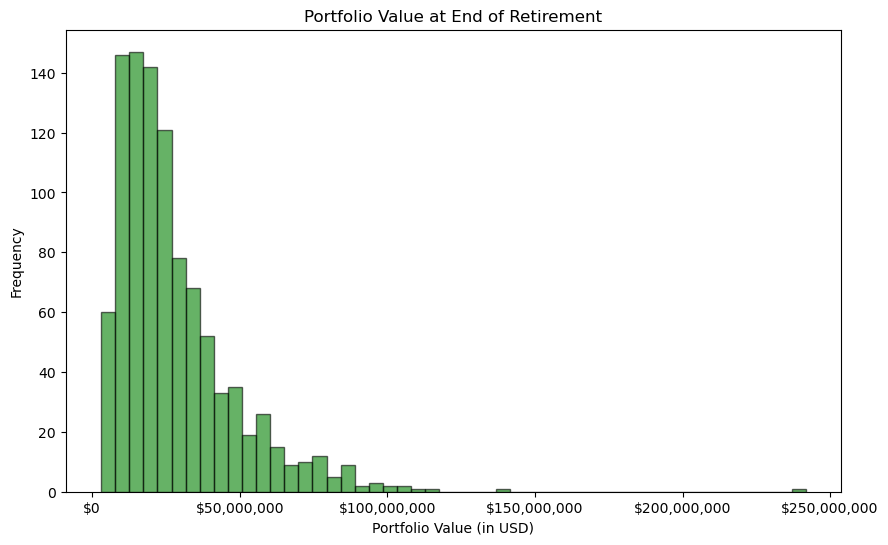

Expected portfolio value at retirement: $2,912,350.78
Expected portfolio value at end of retirement: $22,253,540.37


In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# --- Parameter Definition ---
fund_tickers = ['VTI', 'AGG', 'VOO']  # List of mutual fund or ETF tickers
weights = [0.4, 0.35, 0.25]  # Portfolio weights for each fund
initial_investment = 100000  # Initial investment in USD
annual_contribution = 10000  # Annual contribution in USD
years_to_retirement = 30  # Number of years to retirement
num_simulations = 1000  # Number of Monte Carlo simulations
life_expectancy = 90  # Expected age to live up to
retirement_age = 65  # Age to retire
annual_expenses = 40000  # Annual expenses during retirement in USD
inflation_rate = 0.02  # Expected annual inflation rate

# --- Importing Data ---
# Fetch historical data for the specified mutual fund or ETF tickers using Yahoo Finance.

def fetch_data_yfinance(fund_tickers):
    returns_data = pd.DataFrame()
    expected_returns = []
    
    for ticker in fund_tickers:
        data = yf.download(ticker, period="5y", interval="1mo")
        data['Return'] = data['Adj Close'].pct_change()
        avg_return = data['Return'].mean() * 12  # Annualized monthly return
        expected_returns.append(avg_return)
        returns_data[ticker] = data['Return']
    
    return returns_data, np.array(expected_returns)

# Fetch data
returns_data, expected_returns = fetch_data_yfinance(fund_tickers)
expected_portfolio_return = np.dot(weights, expected_returns)
cov_matrix = returns_data.cov() * 12  # Annualized covariance matrix
expected_portfolio_volatility = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))

print(f'Expected Annual Portfolio Return: {expected_portfolio_return * 100:.2f}%')
print(f'Expected Annual Portfolio Volatility: {expected_portfolio_volatility * 100:.2f}%')

# --- Accumulation Phase Simulation ---

def accumulation_phase_simulation(initial_investment, expected_return, expected_volatility, 
                                  years_to_retirement, annual_contribution, num_simulations):
    final_values = []
    
    for _ in range(num_simulations):
        portfolio_value = initial_investment
        for year in range(years_to_retirement):
            annual_return = np.random.normal(expected_return, expected_volatility)
            portfolio_value = portfolio_value * (1 + annual_return) + annual_contribution
        final_values.append(portfolio_value)
    
    return final_values

# Run Accumulation Phase Simulation
accumulation_results = accumulation_phase_simulation(initial_investment, expected_portfolio_return, 
                                                     expected_portfolio_volatility, years_to_retirement, 
                                                     annual_contribution, num_simulations)

plt.figure(figsize=(10, 6))
plt.hist(accumulation_results, bins=50, color='blue', edgecolor='black', alpha=0.6)
plt.title('Portfolio Value at Retirement')
plt.xlabel('Portfolio Value (in USD)')
plt.ylabel('Frequency')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))
plt.show()

# --- Withdrawal Phase Simulation ---

def withdrawal_phase_simulation(initial_portfolio_value, expected_return, expected_volatility, 
                                 retirement_years, inflation_rate, annual_expenses):
    final_values = []
    
    for _ in range(num_simulations):
        portfolio_value = initial_portfolio_value
        for year in range(retirement_years):
            annual_withdrawal = annual_expenses * ((1 + inflation_rate) ** year)
            portfolio_value -= annual_withdrawal
            if portfolio_value <= 0:
                portfolio_value = 0
                break
            annual_return = np.random.normal(expected_return, expected_volatility)
            portfolio_value = portfolio_value * (1 + annual_return)
        final_values.append(portfolio_value)
    
    return final_values

# Run Withdrawal Phase Simulation
withdrawal_results = withdrawal_phase_simulation(np.median(accumulation_results), expected_portfolio_return, 
                                                 expected_portfolio_volatility, retirement_years, 
                                                 inflation_rate, annual_expenses)

plt.figure(figsize=(10, 6))
plt.hist(withdrawal_results, bins=50, color='green', edgecolor='black', alpha=0.6)
plt.title('Portfolio Value at End of Retirement')
plt.xlabel('Portfolio Value (in USD)')
plt.ylabel('Frequency')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.0f}'))
plt.show()

# Print summary statistics
print(f'Expected portfolio value at retirement: ${np.median(accumulation_results):,.2f}')
print(f'Expected portfolio value at end of retirement: ${np.median(withdrawal_results):,.2f}')
